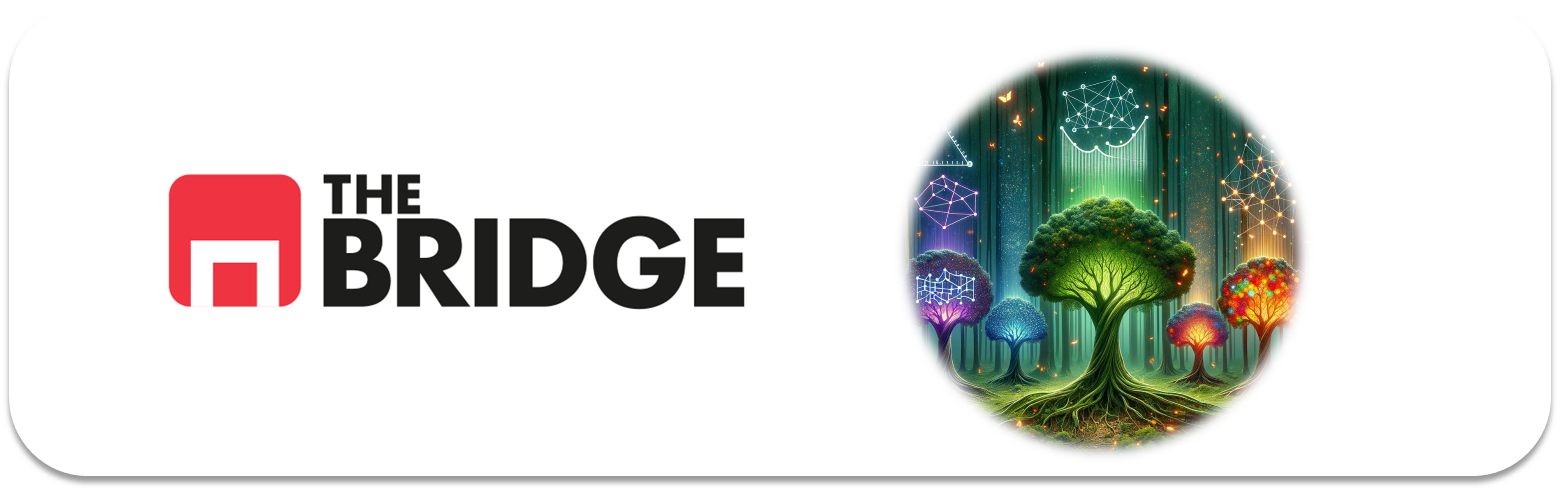

## PRACTICA OBLIGATORIA: **Arboles de Decisión y Ajuste de Hiperparámetros**

* La práctica obligatoria de esta unidad consiste en encontrar el mejor modelo para resolver un problema de predicción de si los destinatarios de una campaña de marketing adquirirán un producto concreto. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

### Descripción

En el directorio data encontrarás un dataset que contiene datos relacionados con campañas de marketing directo de una institución bancaria portuguesa (es el dataset "Bank Marketing" de la UCI Machine Learning Repository). Los datos se recopilaron de campañas de marketing telefónico, donde el objetivo principal era predecir si el cliente se suscribiría a un depósito a plazo.

La práctica consiste en completar el proceso de creación de un modelo basado en árboles de decisión que permita predecir si un cliente (dadas unas características similares a las del dataset) "comprará" el depósito a plazo. Sigue los pasos necesarios de un proceso de ML para crear el modelo, optimizar sus hiperparámetros, comparar los resultados de esa optimización con una regresión logística (sin optimizar, con sus hiperparámetros por defecto) y finalmente evaluarlo contra test y hacer una pequeña valoración del resultado obtenido.

Tendrás que hacer la limpieza, split, minieda, selección, tratamiento, primeros entrenamientos, optimización, comparación y evaluación según tu mejor criterio. Eso sí, es obligatorio:
- Identificar el target y analizar su distribución
- Realizar una optimización de hiperparámetros, escogiendo un grid medianemante razonado
- Comparar con el modelo baseline
- Evaluar contra test

AYUDA: La dirección del banco nos proporciona estas notas (en inglés):

 
   **bank client data:**  
   1 - age (numeric)  
   2 - job : type of job (categorical: "admin.","unknown","unemployed","management","housemaid","entrepreneur","student",
                                       "blue-collar","self-employed","retired","technician","services")   
   3 - marital : marital status (categorical: "married","divorced","single"; note: "divorced" means divorced or widowed)  
   4 - education (categorical: "unknown","secondary","primary","tertiary")  
   5 - default: has credit in default? (binary: "yes","no")  
   6 - balance: average yearly balance, in euros (numeric)   
   7 - housing: has housing loan? (binary: "yes","no")  
   8 - loan: has personal loan? (binary: "yes","no")   

   **related with the last contact of the current campaign:**  
   9 - contact: contact communication type (categorical: "unknown","telephone","cellular")   
  10 - day: last contact day of the month (numeric)  
  11 - month: last contact month of year (categorical: "jan", "feb", "mar", ..., "nov", "dec")  
  12 - duration: last contact duration, in seconds (numeric)    

   **other attributes:**  
  13 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)  
  14 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric, -1 means client was not previously contacted)  
  15 - previous: number of contacts performed before this campaign and for this client (numeric)  
  16 - poutcome: outcome of the previous marketing campaign (categorical: "unknown","other","failure","success")

  

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import bootcampviztools as viz

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    roc_auc_score,
    RocCurveDisplay
)


In [26]:
df = pd.read_csv("data/bank-full.csv", sep=";")

df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


y
no     39922
yes     5289
Name: count, dtype: int64
y
no     0.883015
yes    0.116985
Name: proportion, dtype: float64


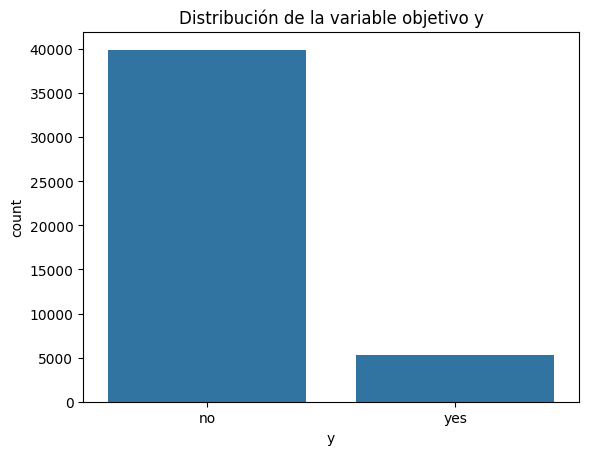

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


,age,balance,day,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


In [27]:
# Distribución de la variable objetivo 'y'
print(df["y"].value_counts())
print(df["y"].value_counts(normalize=True))

sns.countplot(x="y", data=df)
plt.title("Distribución de la variable objetivo y")
plt.show()

# Información general del dataframe
df.info()

# Estadísticos básicos de las numéricas
df.describe()

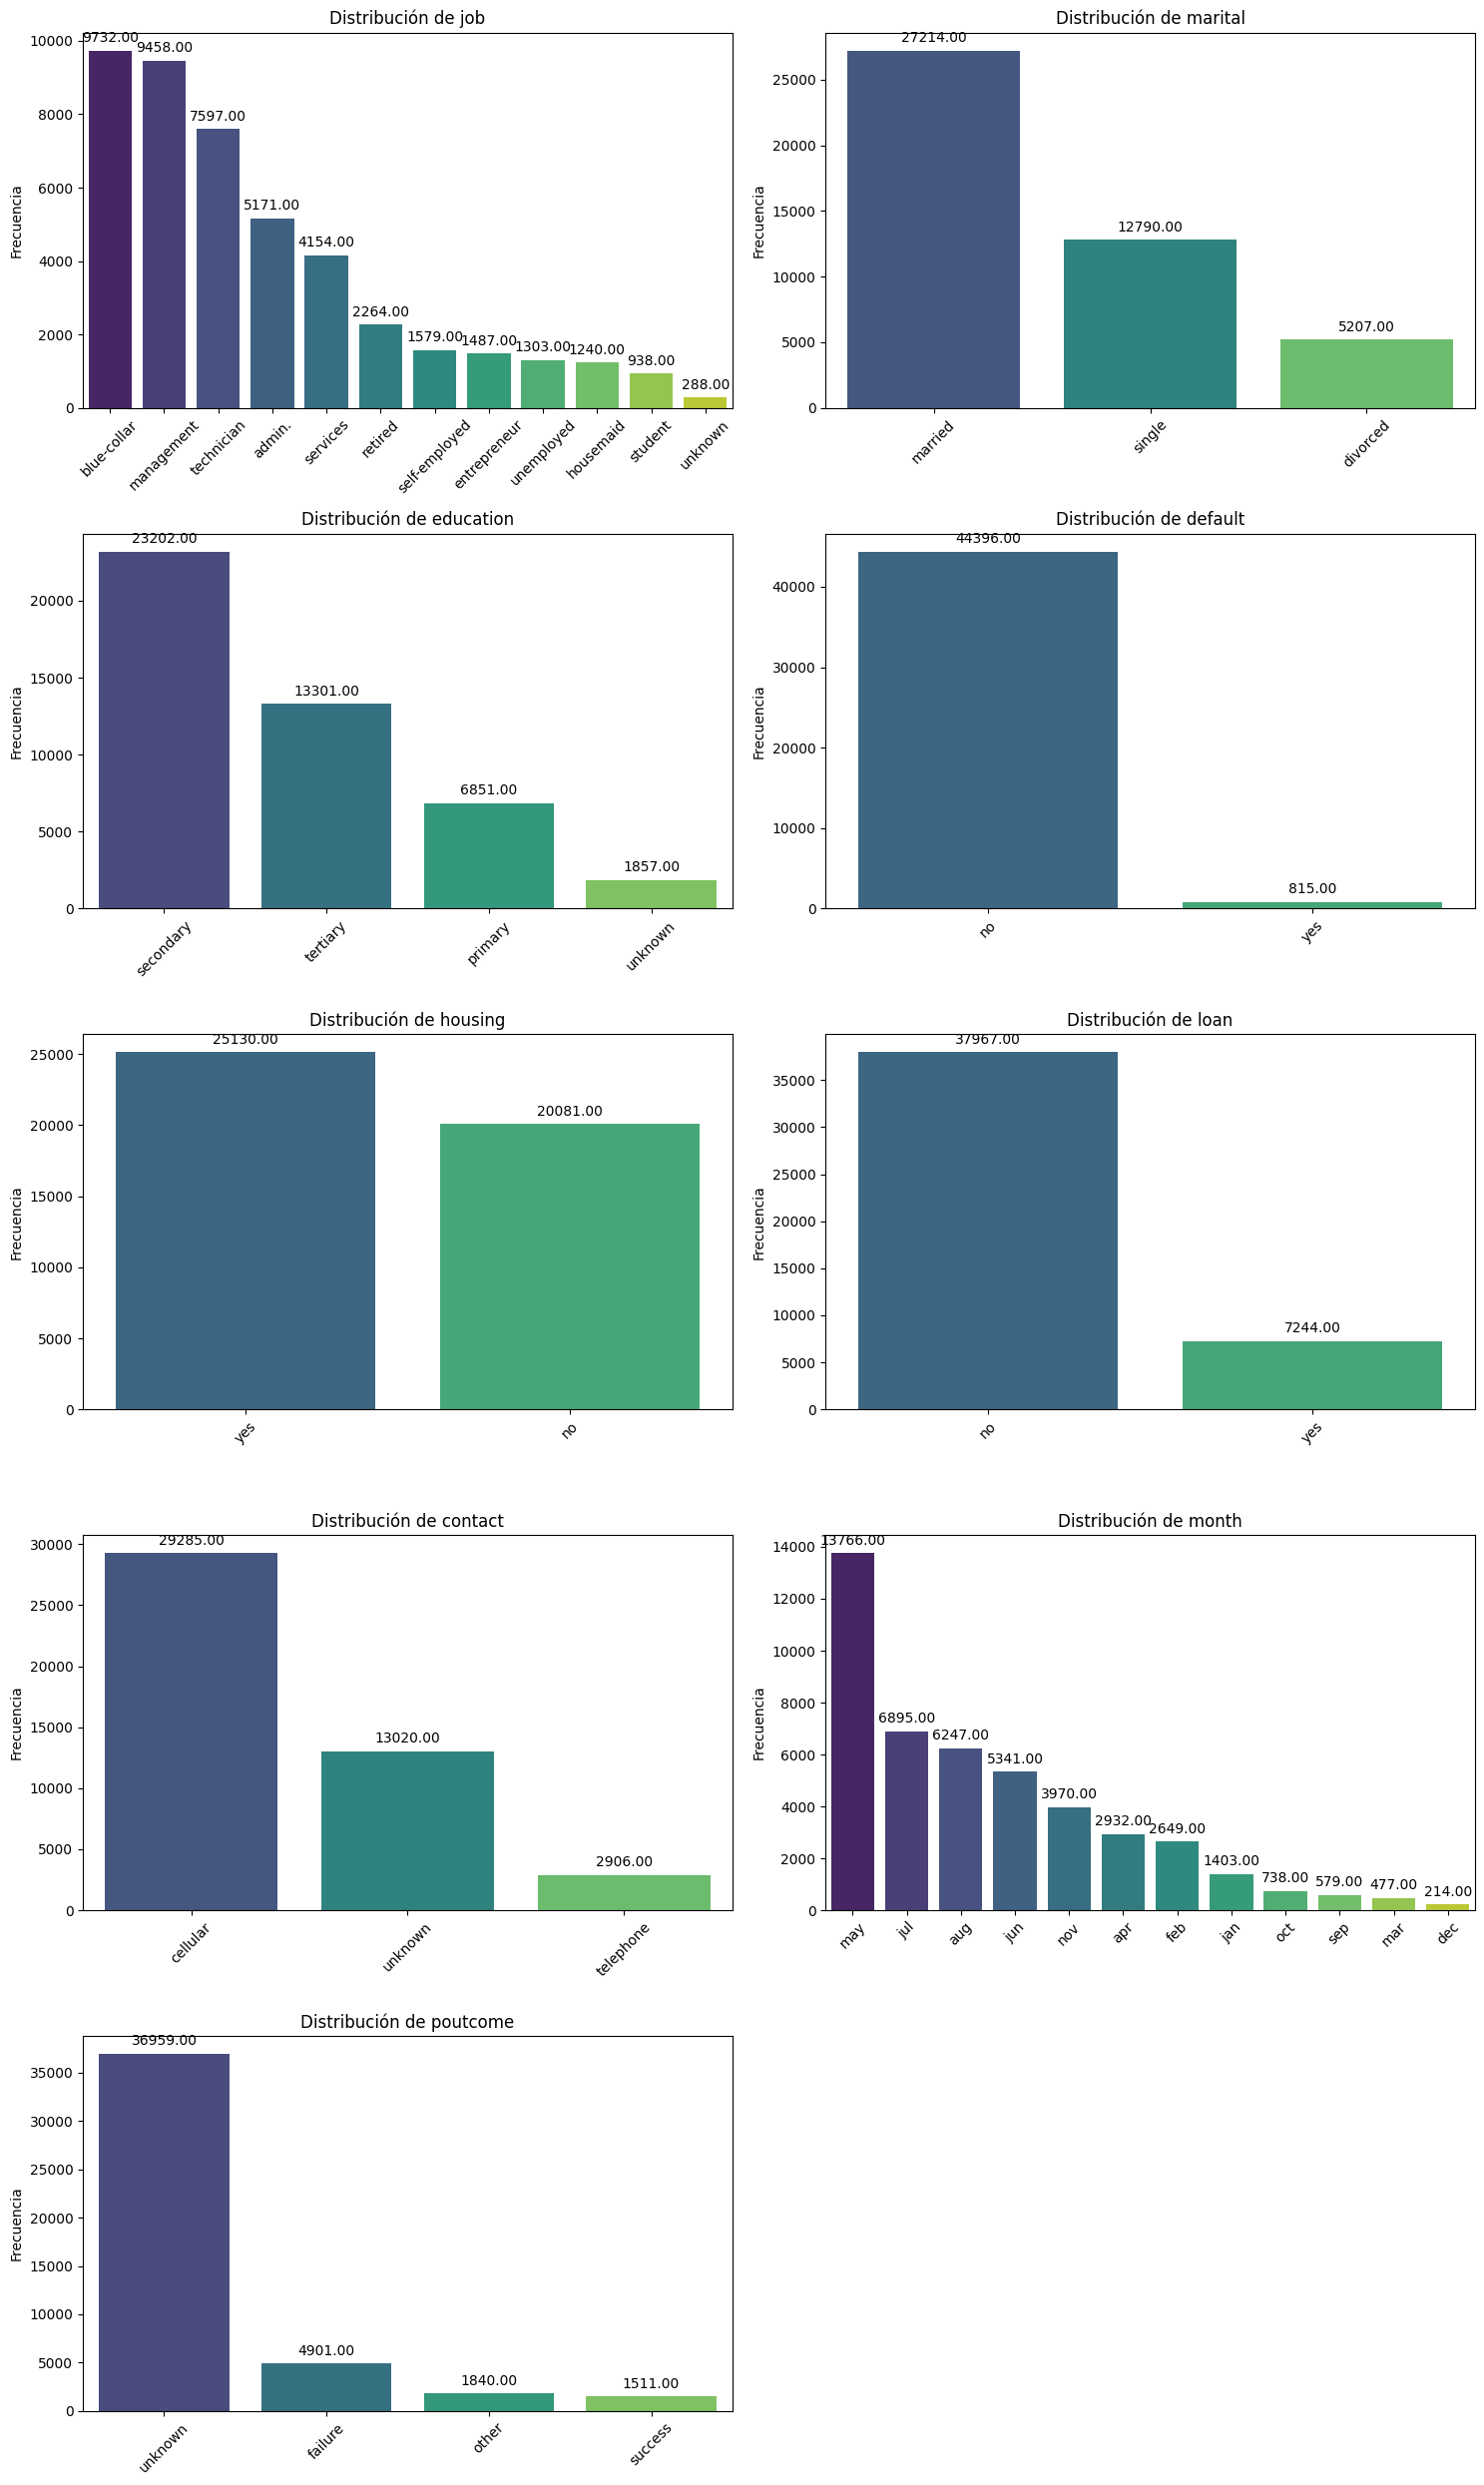

In [28]:
# 3.4 Distribución de algunas variables categóricas
columnas_categoricas_eda = [
    "job", "marital", "education",
    "default", "housing", "loan",
    "contact", "month", "poutcome"
]

viz.pinta_distribucion_categoricas(
    df=df,
    columnas_categoricas=columnas_categoricas_eda,
    relativa=False,          # frecuencias absolutas
    mostrar_valores=True     # muestra los valores encima de cada barra
)

visualizamos la distribución de varias variables categóricas (job, marital, education, etc.). Esto nos ayuda a ver qué categorías son más frecuentes y si hay mucha descompensación en alguna de ellas.

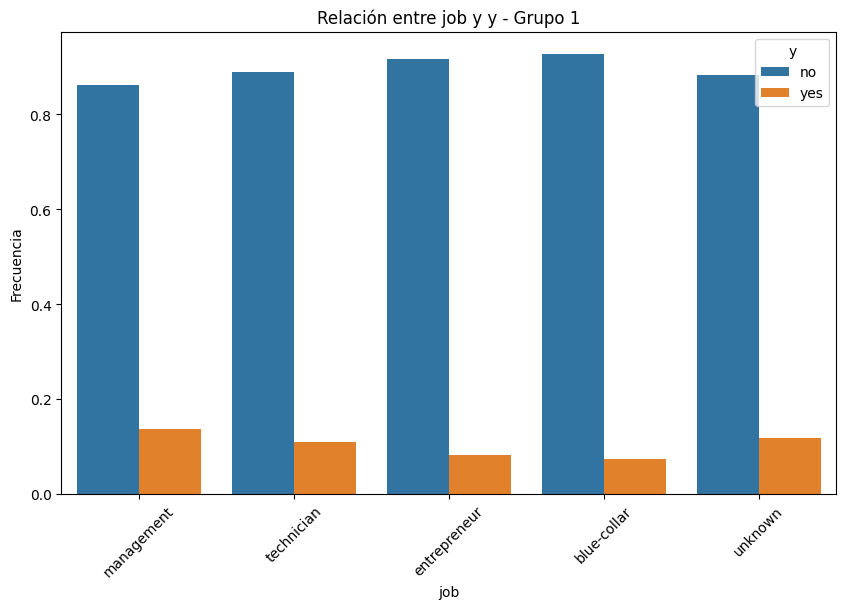

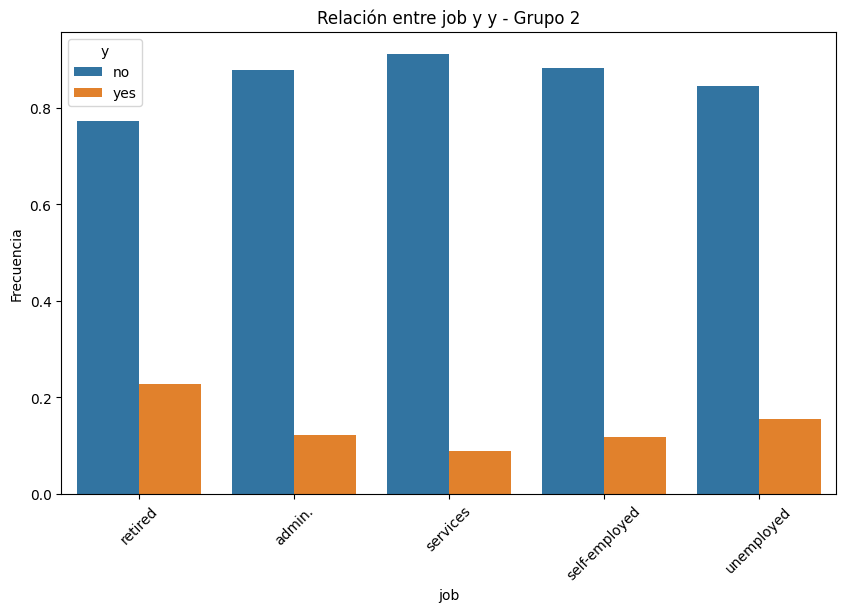

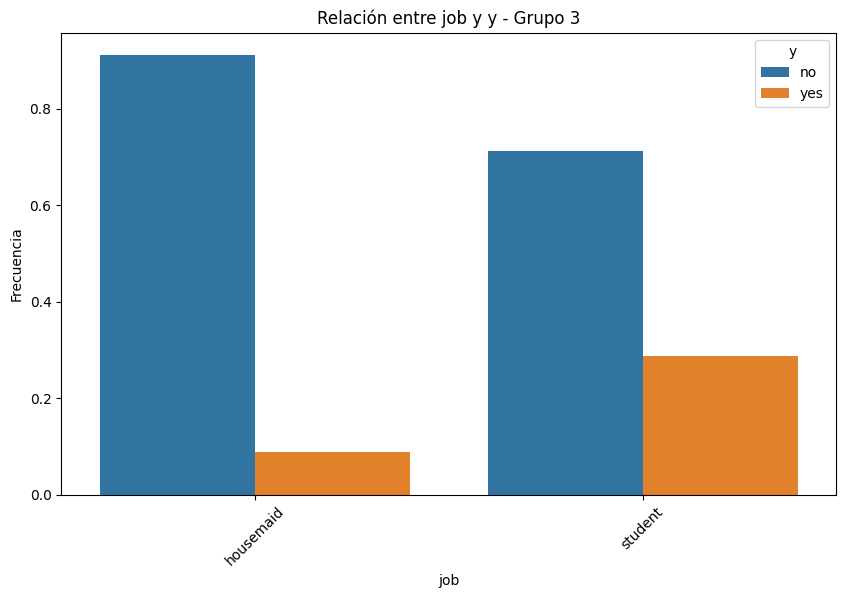

In [29]:
# 3.5 Relación entre una variable categórica y el target 'y'
# Ejemplo: tipo de trabajo vs respuesta de campaña

viz.plot_categorical_relationship_fin(
    df=df,
    cat_col1="job",   # en el eje X
    cat_col2="y",     # en el color (hue)
    relative_freq=True,
    show_values=False
)


En este gráfico analizamos la relación entre `job` y la variable objetivo `y`. Podemos ver qué tipos de trabajo tienen mayor proporción de clientes que contratan el depósito (`yes`) y cuáles prácticamente no lo contratan.

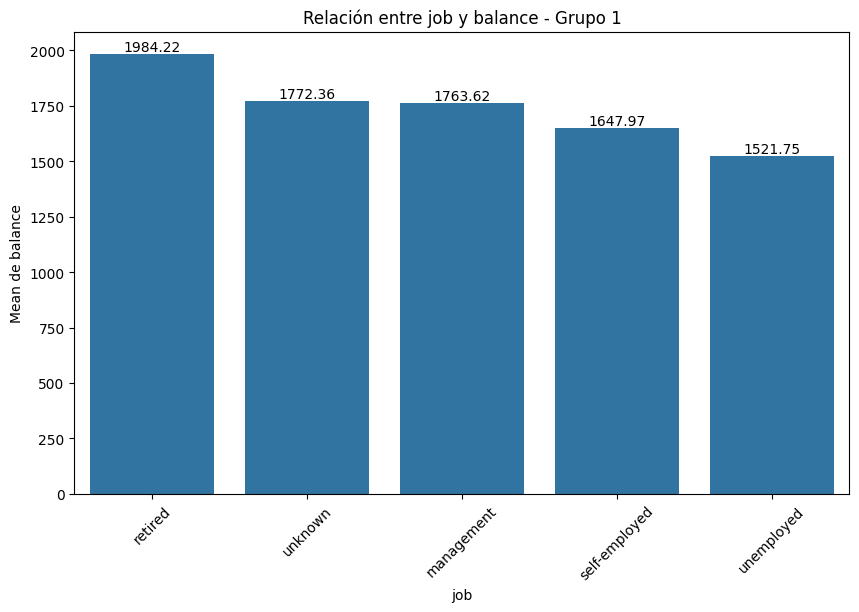

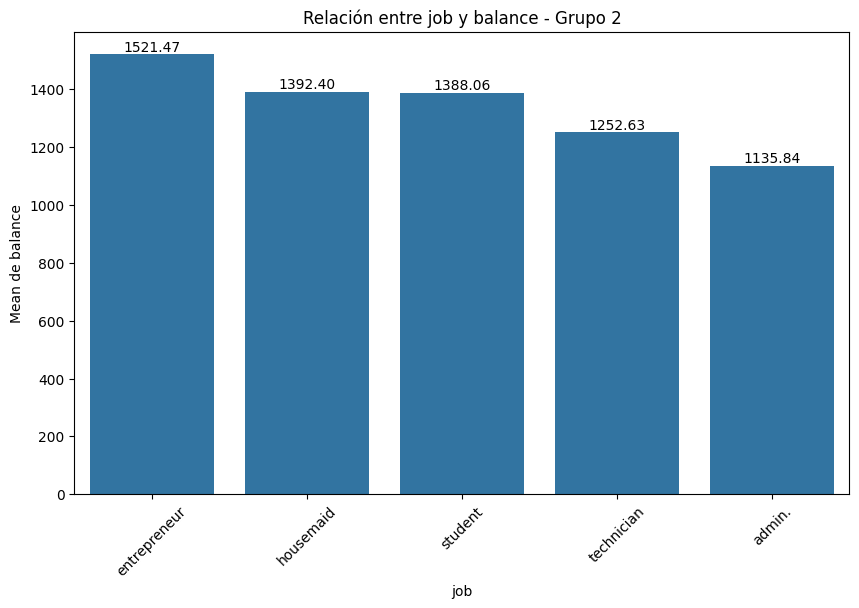

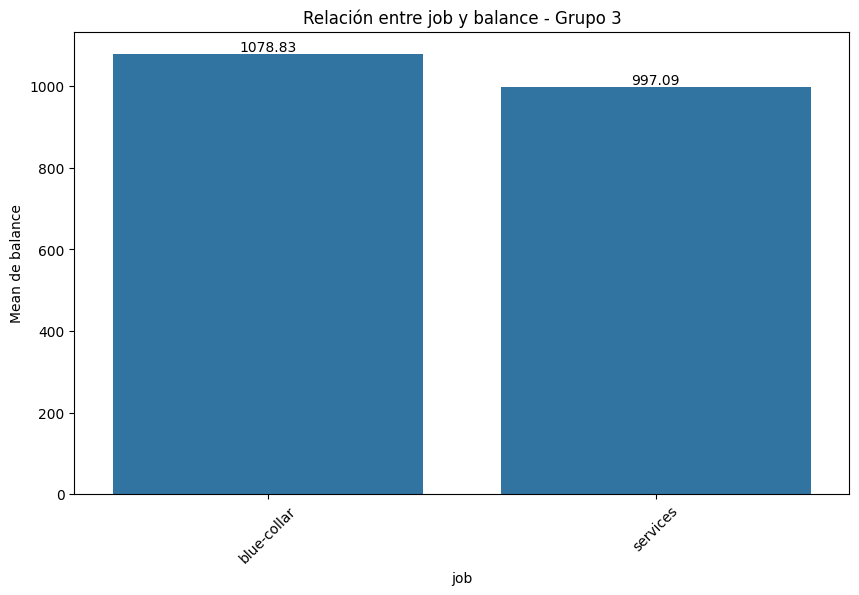

In [30]:
# 3.6 Relación categórica vs numérica (media de balance por tipo de trabajo)

viz.plot_categorical_numerical_relationship(
    df=df,
    categorical_col="job",
    numerical_col="balance",
    show_values=True,
    measure="mean"   # media
)


Aquí estudiamos cómo cambia la media de `balance` según el tipo de trabajo (`job`). Esto nos permite detectar grupos con saldos medios más altos o más bajos, que podrían influir en la probabilidad de contratar el producto.

(7, 2)


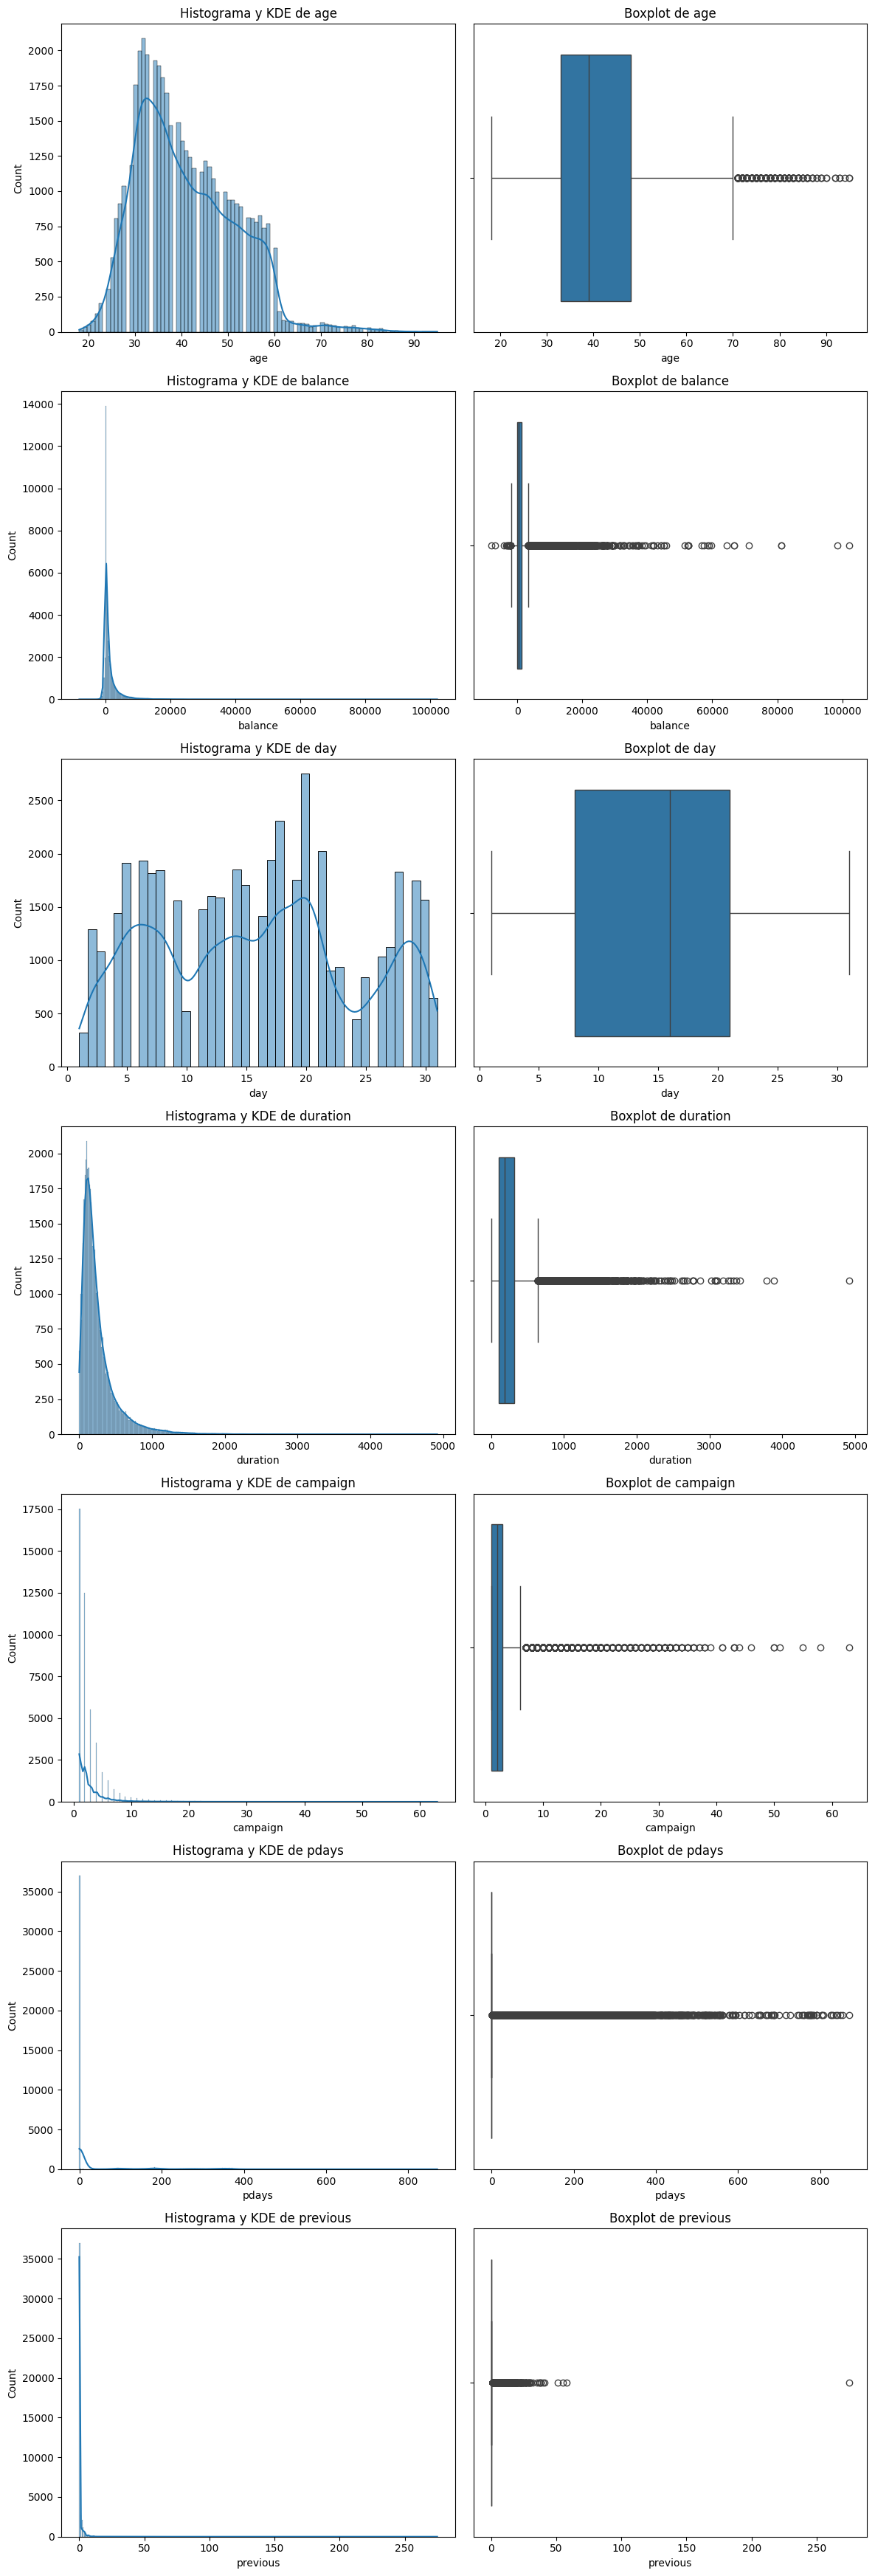

In [31]:
# 3.7 Histogramas + boxplots de algunas numéricas

numeric_cols = ["age", "balance", "day", "duration", "campaign", "pdays", "previous"]

viz.plot_combined_graphs(df, columns=numeric_cols)

Con esta celda generamos histogramas y boxplots de las variables numéricas. Esto nos ayuda a entender la forma de la distribución (asimetrías, colas largas, etc.) y a detectar posibles outliers en variables como `balance` o `duration`.

3. Preparación de datos y definición de X / y

In [32]:
data = df.copy()

# Pasamos la variable objetivo de 'yes'/'no' a 1/0
data["y_bin"] = data["y"].map({"no": 0, "yes": 1})

# Eliminamos la columna original 'y' porque ya tenemos la versión binaria
data = data.drop(columns=["y"])

# Definimos de nuevo las columnas numéricas y categóricas
numeric_cols = ["age", "balance", "day", "duration", "campaign", "pdays", "previous"]
categorical_cols = ["job", "marital", "education", "default",
                    "housing", "loan", "contact", "month", "poutcome"]

# Matriz de features (X) y vector objetivo (y)
X = data[numeric_cols + categorical_cols]
y = data["y_bin"]

print("Shape de X:", X.shape)
print("Shape de y:", y.shape)

Shape de X: (45211, 16)
Shape de y: (45211,)



En esta parte preparamos los datos para el modelo: creamos la variable objetivo binaria `y_bin` (0 = no contrata, 1 = sí contrata), eliminamos la columna original `y` y definimos las columnas numéricas y categóricas que usaremos como variables explicativas (`X`) y el vector objetivo (`y`).

4. Train / Test split

In [33]:
# TRAIN / TEST SPLIT

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,        # 20% para test
    random_state=42,      # reproducible
    stratify=y            # mantiene proporción de clases
)

print("X_train:", X_train.shape)
print("X_test:", X_test.shape)

X_train: (36168, 16)
X_test: (9043, 16)


Dividimos el dataset en entrenamiento (80%) y test (20%) usando `train_test_split`. Usamos `stratify=y` para mantener la misma proporción de clases en train y test, y fijamos `random_state` para que los resultados sean reproducibles.

5. Preprocesador (OneHotEncoder) + Árbol básico

In [34]:
# =========================
# 6. PREPROCESADOR
# =========================
# - Categóricas: OneHotEncoder
# - Numéricas: se dejan tal cual (passthrough)

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
        ("num", "passthrough", numeric_cols)
    ]
)

# =========================
# 7. MODELO DE ÁRBOL BÁSICO
# =========================

tree_clf = DecisionTreeClassifier(random_state=42)

# =========================
# 8. PIPELINE COMPLETO
# =========================

clf = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("model", tree_clf)
    ]
)

# Entrenamos el modelo con los datos de entrenamiento
clf.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocess', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('cat', ...), ('num', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers cont

Construimos un `ColumnTransformer` que aplica `OneHotEncoder` a las variables categóricas y deja pasar las numéricas sin cambios. Después definimos un árbol de decisión básico (`DecisionTreeClassifier`) y montamos un `Pipeline` que encadena preprocesado + modelo. Finalmente entrenamos el modelo con los datos de entrenamiento.

6. Evaluación del árbol básico

In [35]:
# =========================
# 9. PREDICCIONES
# =========================

y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)

# Probabilidades para ROC-AUC
y_test_proba = clf.predict_proba(X_test)[:, 1]

# =========================
# 10. MÉTRICAS
# =========================

accuracy_train = accuracy_score(y_train, y_train_pred)
accuracy_test  = accuracy_score(y_test, y_test_pred)
precision_test = precision_score(y_test, y_test_pred)
recall_test    = recall_score(y_test, y_test_pred)
f1_test        = f1_score(y_test, y_test_pred)
roc_auc        = roc_auc_score(y_test, y_test_proba)

print("Accuracy (train):", accuracy_train)
print("Accuracy (test): ", accuracy_test)
print("Precision (test):", precision_test)
print("Recall (test):   ", recall_test)
print("F1 (test):       ", f1_test)
print("ROC-AUC (test):  ", roc_auc)

Accuracy (train): 1.0
Accuracy (test):  0.8737144752847507
Precision (test): 0.46111111111111114
Recall (test):    0.4706994328922495
F1 (test):        0.46585594013096354
ROC-AUC (test):   0.6989063852000384


Calculamos las métricas principales del modelo básico: accuracy en train y test, precision, recall, F1 y ROC-AUC sobre el conjunto de test. Vemos que el árbol obtiene una accuracy muy alta en train (casi 1), lo que indica sobreajuste, y métricas más moderadas en test, especialmente para la clase positiva (`yes`).

[[7403  582]
 [ 560  498]]


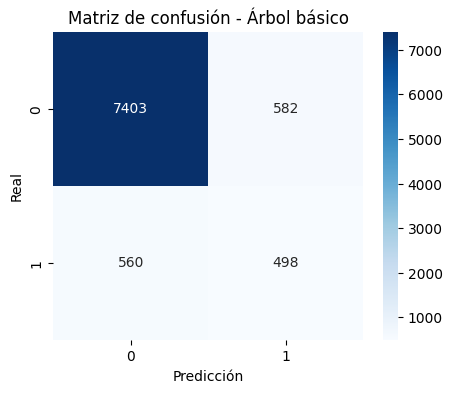

In [36]:
# =========================
# 11. MATRIZ DE CONFUSIÓN
# =========================

cm = confusion_matrix(y_test, y_test_pred)
print(cm)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de confusión - Árbol básico")
plt.show()


La matriz de confusión nos permite ver cuántos casos se clasifican correctamente y cuántos se confunden entre las clases. Interpretamos los cuatro valores:  
- **TN**: clientes que no contratan y el modelo acierta.  
- **FP**: clientes que no contratan pero el modelo dice que sí (falsas alarmas).  
- **FN**: clientes que sí contratan pero el modelo dice que no (oportunidades perdidas).  
- **TP**: clientes que sí contratan y el modelo acierta.  
Esto ayuda a valorar el coste de cada tipo de error en el contexto del banco.

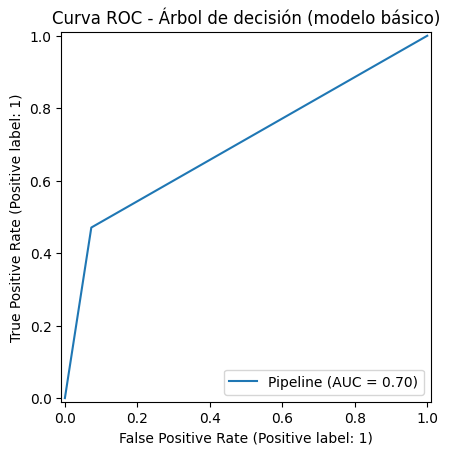

In [37]:
# =========================
# 12. CURVA ROC
# =========================

RocCurveDisplay.from_estimator(clf, X_test, y_test)
plt.title("Curva ROC - Árbol de decisión (modelo básico)")
plt.show()

La curva ROC muestra el compromiso entre tasa de verdaderos positivos (TPR) y tasa de falsos positivos (FPR) para diferentes umbrales de decisión. El área bajo la curva (ROC-AUC) resume la capacidad del modelo para separar las clases: cuanto más cercana a 1, mejor separación.

🎛️ 7. GridSearch de hiperparámetros

In [38]:
# =========================
# 13. GRID SEARCH
# =========================
# Probamos varios valores para los hiperparámetros principales del árbol

param_grid = {
    "model__max_depth": [3, 5, 7],
    "model__min_samples_split": [2, 50],
    "model__min_samples_leaf": [1, 20],
    "model__criterion": ["gini", "entropy"]
}

grid_search = GridSearchCV(
    estimator=clf,      # nuestro pipeline
    param_grid=param_grid,
    cv=3,               # 3 folds
    scoring="f1",       # optimizamos F1 de la clase positiva
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

print("Mejores hiperparámetros:", grid_search.best_params_)
print("Mejor F1 (CV):", grid_search.best_score_)

Fitting 3 folds for each of 24 candidates, totalling 72 fits
Mejores hiperparámetros: {'model__criterion': 'gini', 'model__max_depth': 7, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2}
Mejor F1 (CV): 0.478934044915114


En esta celda usamos `GridSearchCV` para buscar la combinación de hiperparámetros del árbol que maximiza la métrica F1. Probamos distintos valores de `max_depth`, `min_samples_split`, `min_samples_leaf` y `criterion`. Esto nos permite controlar la complejidad del árbol y reducir el sobreajuste.

🌳 8. Evaluación del mejor modelo

Accuracy (test) - best: 0.898595598805706
Precision (test) - best: 0.6082949308755761
Recall (test) - best:    0.3742911153119093
F1 (test) - best:        0.46342890579286133
ROC-AUC (test) - best:   0.8629404968910279


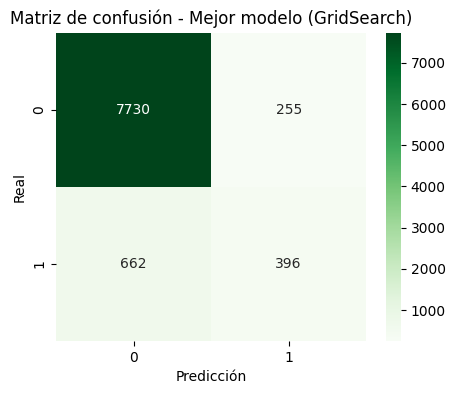

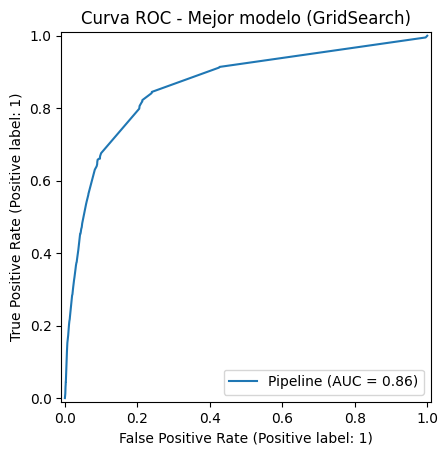

In [39]:
# =========================
# 14. EVALUAR MEJOR MODELO
# =========================

best_clf = grid_search.best_estimator_

y_test_pred_best = best_clf.predict(X_test)
y_test_proba_best = best_clf.predict_proba(X_test)[:, 1]

print("Accuracy (test) - best:", accuracy_score(y_test, y_test_pred_best))
print("Precision (test) - best:", precision_score(y_test, y_test_pred_best))
print("Recall (test) - best:   ", recall_score(y_test, y_test_pred_best))
print("F1 (test) - best:       ", f1_score(y_test, y_test_pred_best))
print("ROC-AUC (test) - best:  ", roc_auc_score(y_test, y_test_proba_best))

cm_best = confusion_matrix(y_test, y_test_pred_best)
plt.figure(figsize=(5,4))
sns.heatmap(cm_best, annot=True, fmt="d", cmap="Greens")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de confusión - Mejor modelo (GridSearch)")
plt.show()

RocCurveDisplay.from_estimator(best_clf, X_test, y_test)
plt.title("Curva ROC - Mejor modelo (GridSearch)")
plt.show()




Evaluamos en el conjunto de test el mejor modelo encontrado por `GridSearchCV`. Comparamos sus métricas (accuracy, precision, recall, F1 y ROC-AUC) con las del árbol básico. Normalmente, el modelo ajustado tiene menor sobreajuste y un mejor equilibrio entre precision y recall para la clase positiva.

👁️ 9. Visualizar parte del árbol

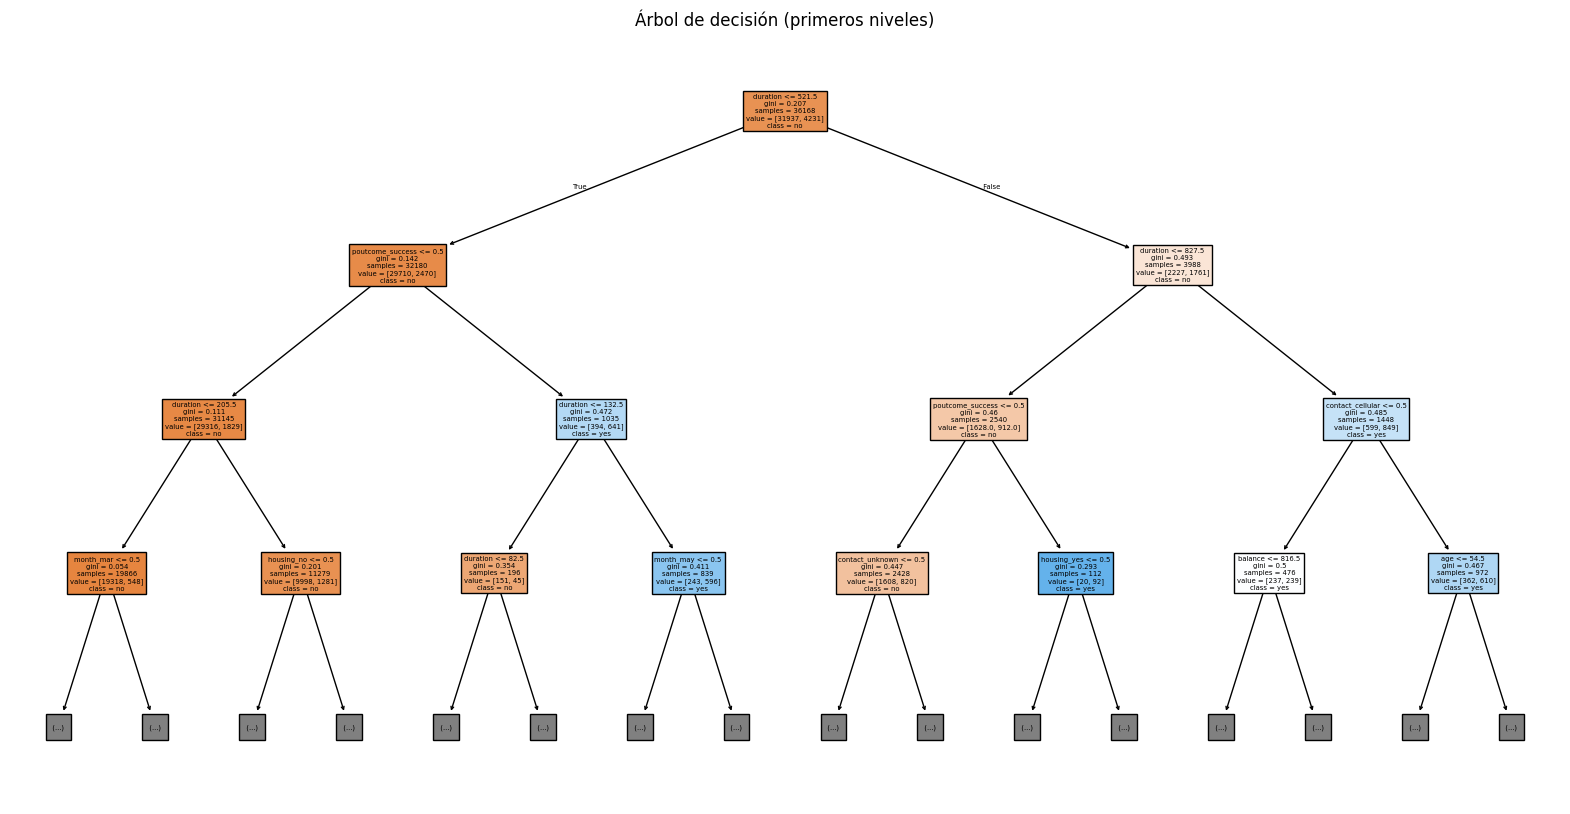

In [40]:
# =========================
# 15. VISUALIZACIÓN DEL ÁRBOL
# =========================

# Extraemos el árbol del pipeline
best_tree = best_clf.named_steps["model"]

# Nombres de las columnas tras OneHotEncoder
ohe = best_clf.named_steps["preprocess"].named_transformers_["cat"]
ohe_feature_names = ohe.get_feature_names_out(categorical_cols)
all_feature_names = np.concatenate([ohe_feature_names, numeric_cols])

plt.figure(figsize=(20, 10))
plot_tree(
    best_tree,
    feature_names=all_feature_names,
    class_names=["no", "yes"],
    filled=True,
    max_depth=3     # solo mostramos los primeros niveles para que se entienda
)
plt.title("Árbol de decisión (primeros niveles)")
plt.show()

Por último, visualizamos los primeros niveles del árbol de decisión entrenado con los mejores hiperparámetros. Esto nos ayuda a interpretar el modelo: vemos qué variables aparecen cerca de la raíz (más importantes), qué umbrales se usan para dividir y cómo se van separando los clientes en función de sus características.